# Import packages

In [1]:
import face_recognition, face_rec
from common_functionality import *
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
import shutil   # ONLY USED FOR CLEARING EXISTING ROIS
%matplotlib inline

# JSON functionality

<b>NOTE: Data folder must contain video data before running below two functions</b>

In [2]:
# Function to grab necessary data from frame
def get_frame_data(file_path, base_img_name):
    with open(file_path, 'r+') as f:
        processed_data = json.load(f)
        if 'frames_list' not in processed_data.keys():
            processed_data['frames_list'] = []
        
        for index, frame in enumerate(processed_data['frames_list']):
            if frame['frame_num'] == base_img_name:
                frame_dict = frame.copy()
                pos = index
                break
        
    return frame_dict

# Function to grab necessary data from facial ROI extracted from frame
def get_roi_data(file_path, base_img_name, roi_name):
    with open(file_path, 'r+') as f:
        processed_data = json.load(f)
        if 'frames_list' not in processed_data.keys():
            processed_data['frames_list'] = []
        
        for index, frame in enumerate(processed_data['frames_list']):
            if frame['frame_num'] == base_img_name:
                frame_dict = frame.copy()
                pos = index
                break
        
        for index_r, roi in enumerate(processed_data['frames_list'][pos]['rois_list']):
            if roi['roi_num'] == roi_name:
                roi_dict = roi.copy()
                roi_pos = index_r
                break
        
    return roi_dict

# Parameter declaration and initialisation

In [3]:
padding = 10
frame_visuals_dir = 'frame_visuals'

## Creating ROIs directory if it does not exist

In [4]:
if not os.path.exists(frame_visuals_dir):
    os.mkdir(frame_visuals_dir)

# Selecting video frames folder (only for testing purposes)

In [5]:
vid_frames_folders = [folder for folder in os.listdir(".") if os.path.isdir(os.path.join(".", folder)) and folder.startswith("vid_frames")]

for index, frames_dir in enumerate(vid_frames_folders):
    print(f'{index+1}: {frames_dir}')

1: vid_frames
2: vid_frames_ml


In [6]:
valid_choice = False
while not valid_choice:
    index_choice = input('Enter index of video frames directory: ')

    if index_choice.isnumeric():
        if int(index_choice) > len(vid_frames_folders) or int(index_choice) <= 0:
            valid_choice = False
            print('Invalid choice!')
        else:
            valid_choice = True
            frames_dir = vid_frames_folders[int(index_choice)-1]
            rois_dir = f'face_rois_dt_{"_".join(frames_dir.split("_")[2:])}' if frames_dir != "vid_frames" else "face_rois_dt"
            video_data_path = os.path.join('data', f'video_data_{"_".join(frames_dir.split("_")[2:])}') if frames_dir != "vid_frames" else os.path.join('data', 'video_data')
            print("Video Frames Folder selected:", frames_dir)
            print(rois_dir)

    else:
        valid_choice = False
        print("Index entered is not numeric!")

Video Frames Folder selected: vid_frames
face_rois_dt


# Facial ROI execution

## Asking user for directory of video to process

In [7]:
frames_subDirs = []

print('List of available of videos with extracted frames:')
for root, dirs, files in os.walk(frames_dir, topdown=True):
    for subDir in dirs:
        frames_subDirs.append(subDir)

frames_subDirs_sorted = sorted(frames_subDirs, key=lambda x: int(x.split('_')[-1]))

for index, subDir in enumerate(frames_subDirs_sorted):
    print(f'{index+1}: {os.path.join(frames_dir, subDir)}')

List of available of videos with extracted frames:
1: vid_frames\video_1
2: vid_frames\video_2
3: vid_frames\video_3
4: vid_frames\video_4
5: vid_frames\video_5
6: vid_frames\video_6
7: vid_frames\video_7
8: vid_frames\video_8
9: vid_frames\video_9
10: vid_frames\video_10
11: vid_frames\video_11
12: vid_frames\video_12
13: vid_frames\video_13
14: vid_frames\video_14
15: vid_frames\video_15
16: vid_frames\video_16
17: vid_frames\video_17
18: vid_frames\video_18
19: vid_frames\video_19
20: vid_frames\video_20
21: vid_frames\video_21
22: vid_frames\video_22


In [47]:
valid_choice = False
dir_chosen = ""
dir_chosen_full_path = ""
while not valid_choice:
    index_choice = input('Enter index of directory that you want to retrieve face ROIs: ')

    if index_choice.isnumeric():
        if int(index_choice) > len(frames_subDirs_sorted) or int(index_choice) <= 0:
            valid_choice = False
            print('Invalid choice!')
        else:
            valid_choice = True
            dir_chosen = frames_subDirs_sorted[int(index_choice)-1]
            dir_chosen_full_path = os.path.join(frames_dir, dir_chosen)
            chosen_video_data_path = os.path.join(video_data_path, f'{dir_chosen}.json')
            print("Directory selected:", dir_chosen_full_path)
            print("Video selected:", dir_chosen)
    else:
        valid_choice = False
        print("Index entered is not numeric!")

Directory selected: vid_frames\video_16
Video selected: video_16


In [48]:
visuals_path = os.path.join(frame_visuals_dir, dir_chosen) if "_ml" not in frames_dir else os.path.join(frame_visuals_dir, f'{dir_chosen}_ml')
if not os.path.exists(visuals_path):
    os.mkdir(visuals_path)

In [37]:
#NOTE: ONLY TO BE USED TO PROCESS THE VIDEOS DONE BY MARK LAWRENCE
# visuals_path = os.path.join(frame_visuals_dir, f'{dir_chosen}_ml')
# if not os.path.exists(visuals_path):
#     os.mkdir(visuals_path)

## Validate if video data exists

In [49]:
# Check if data file for selected video exists in the data folder
video_data_file_exists = check_if_data_file_exists(dir_chosen)

if not video_data_file_exists:
    raise Exception(f'Data file for {dir_chosen} does not exist in {video_data_path}!')
    exit(0)

# Check if there is a list of extracted frames in the selected video data file
video_data_exists = validate_data_file(chosen_video_data_path)

if not video_data_exists:
    raise Exception(f'Please ensure that all frames from {dir_chosen} have been extracted before running this!')
    exit(0)

print("Chosen video data file is valid!")

Chosen video data file is valid!


In [25]:
# TESTING PURPOSES
if video_data_exists:
    snapshot_img = 'frame_0033.png'
    if snapshot_img.endswith('.jpg') or snapshot_img.endswith('.png'):
        snapshot_path = os.path.join(dir_chosen_full_path, snapshot_img)
        snapshot_basename = os.path.splitext(os.path.basename(snapshot_img))[0]
        snapshot_ext = os.path.splitext(os.path.basename(snapshot_img))[1]
        snapshot_data = get_frame_data(chosen_video_data_path, snapshot_basename)
        print(snapshot_data)
        snapshot_roi = 'frame_0033_00'
        roi_data = get_roi_data(chosen_video_data_path, snapshot_basename, snapshot_roi)
        print(roi_data)
    

{'frame_num': 'frame_0033', 'frame_timestamp': '0:06:45', 'num_of_rois': 1, 'rois_list': [{'roi_num': 'frame_0033_00', 'facial_encoding': {'x': 347, 'y': 94, 'w': 91, 'h': 135}, 'person_classified': 'interviewee', 'emotion_classified': 'neutral', 'person_score': 0.4999213393017777, 'emotion_probabilities': {'angry': 0.4041614251829043, 'disgust': 6.402290104285205e-12, 'fear': 1.0034758333984357e-05, 'happy': 2.0170339846011658e-05, 'sad': 0.3543129634820201, 'surprise': 1.762956205628708e-09, 'neutral': 99.24149508723588}, 'entropy': 0.04982769539093216, 'predicted_arousal': 0.001007928146979462, 'predicted_valence': -0.004954906595996678}]}
{'roi_num': 'frame_0033_00', 'facial_encoding': {'x': 347, 'y': 94, 'w': 91, 'h': 135}, 'person_classified': 'interviewee', 'emotion_classified': 'neutral', 'person_score': 0.4999213393017777, 'emotion_probabilities': {'angry': 0.4041614251829043, 'disgust': 6.402290104285205e-12, 'fear': 1.0034758333984357e-05, 'happy': 2.0170339846011658e-05, 's

## Generate bounding boxes for each frame and write results

640 - 360


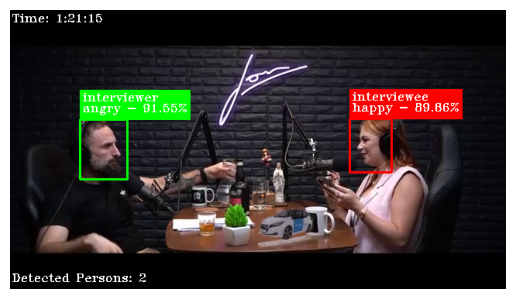

In [50]:
total_num_rois_extracted = 0

font = cv2.FONT_HERSHEY_TRIPLEX
font_scale = 0.5
font_thickness = 1

if video_data_exists:
    # Loop through each file in the directory
    for i, snapshot_img in enumerate(os.listdir(dir_chosen_full_path)):
        roi_names = []

        # Only take into account image files (which end in .jpg or .png)
        if snapshot_img.endswith('.jpg') or snapshot_img.endswith('.png'):
            snapshot_path = os.path.join(dir_chosen_full_path, snapshot_img)
            snapshot_basename = os.path.splitext(os.path.basename(snapshot_img))[0]
            snapshot_ext = os.path.splitext(os.path.basename(snapshot_img))[1]
            snapshot_data = get_frame_data(chosen_video_data_path, snapshot_basename)
            #print(snapshot_data)

            # Load and crop image to avoid extracting faces from any ads from the bottom of the screen
            snapshot = face_rec.load_image_file(snapshot_path)
            snapshot = cv2.cvtColor(snapshot, cv2.COLOR_BGR2RGB)
            snapshot_copy = snapshot.copy()
            frame_time = snapshot_data['frame_timestamp']
            roi_predict_num = snapshot_data['num_of_rois']
            actual_faces = len(snapshot_data['rois_list'])

            snapshot_h, snapshot_w, _ = snapshot_copy.shape
            print(snapshot_w, "-", snapshot_h)

            # Put text displaying time
            cv2.putText(snapshot_copy, f'Time: {frame_time}', (2, 5+(font_thickness*10)), font, font_scale, (255, 255, 255), font_thickness)
            
            for roi in snapshot_data['rois_list']:
                roi_filename = roi['roi_num']
                roi_data = get_roi_data(chosen_video_data_path, snapshot_basename, roi_filename)
                #print(roi_data)

                encoding = roi['facial_encoding']

                roi_x = encoding['x']
                roi_y = encoding['y']
                roi_w = encoding['w']
                roi_h = encoding['h']
                roi_left, roi_right = roi_x - padding, roi_x + roi_w + padding
                roi_top, roi_bottom = roi_y - padding, roi_y + roi_h + padding

                # Ensure dimensions are greater than 0 to avoid any errors
                if roi_top < 0:
                    roi_top = 0
                
                if roi_left < 0:
                    roi_left = 0

                if roi_data['person_classified'] == 'unknown':
                    actual_faces -= 1
                    continue
                
                person_detected = roi_data['person_classified']
                dom_emotion = roi_data['emotion_classified']
                dom_emotion_prob = roi_data['emotion_probabilities'][dom_emotion]

                #text = f"{person_detected} - {dom_emotion}"
                text = f"{person_detected}\n{dom_emotion} - {dom_emotion_prob:.2f}%"
                lines = text.split('\n')
                text_sizes = [cv2.getTextSize(line, font, font_scale, font_thickness)[0] for line in lines]
                max_text_width = max([w for w, h in text_sizes])
                text_height = text_sizes[0][1]  # Height is roughly the same for all lines at the same font size
                line_height = int(text_height * 1.2)  # Add some spacing between lines
                #(text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, font_thickness)

                # Coordinates for the filled rectangle (above the top-left corner of the bounding box)
                rect_x1 = roi_left
                #rect_y1 = roi_top - text_height - 10 if roi_top - text_height - 10 > 0 else roi_top + text_height + 10
                rect_x2 = roi_left + max_text_width + 6
                #rect_y2 = roi_top if roi_top - text_height - 10 > 0 else roi_top + text_height + 24
                num_lines = len(lines)
                total_text_height = int(text_height * 1.2 * num_lines)
                if roi_top - total_text_height - 10 > 0:
                    rect_y1 = roi_top - total_text_height - 10
                    rect_y2 = roi_top
                else:
                    rect_y1 = roi_bottom# + text_height + 10
                    rect_y2 = rect_y1 + total_text_height + 4
                
                box_colour = None
                box_colour = None
                if roi_data['person_classified'] == 'interviewer':
                    box_colour = (0, 255, 0)
                else:
                    box_colour = (0, 0, 255)
                    
                # Draw bounding box
                cv2.rectangle(snapshot_copy, (roi_left, roi_top), (roi_right, roi_bottom), box_colour, 2)

                # Draw filled rectangle
                cv2.rectangle(snapshot_copy, (rect_x1, rect_y1), (rect_x2, rect_y2), box_colour, -1)

                # Put text over the rectangle
                for i, line in enumerate(lines):
                    y_position = rect_y1 + (i + 1) * line_height if roi_top - text_height - 10 > 0 else rect_y1 + (i + 1) * line_height
                    cv2.putText(snapshot_copy, line, (rect_x1 + 3, y_position), font, font_scale, (255, 255, 255), font_thickness)
                #cv2.putText(snapshot_copy, text, (rect_x1 + 3, rect_y2 - 5), font, font_scale, (255, 255, 255), font_thickness)
            
            # Put text displaying number of detected persons
            cv2.putText(snapshot_copy, f'Detected Persons: {actual_faces}', (2, snapshot_h-(font_thickness*10)), font, font_scale, (255, 255, 255), font_thickness)

        #cv2.imshow(f"Visualisation of {snapshot_basename}", snapshot_copy)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        snapshot_rgb = cv2.cvtColor(snapshot_copy, cv2.COLOR_BGR2RGB)

        plt.imshow(snapshot_rgb)
        plt.axis('off')  # Optional: turn off axis
        plt.show()

        cv2.imwrite(os.path.join(visuals_path, snapshot_img), snapshot_copy)
        # Inform user that facial ROI extraction process is complete
        #print(f"A total of {total_num_rois_extracted} facial ROIs for {dir_chosen} have been saved in {rois_subDir}")
else:
    raise Exception(f'Please ensure that all frames from {dir_chosen} have been extracted before running this!')